## 모체 혈장 내 유리 DNA를 이용한 비침습적 산전검사

다운증후군은(3염색체성(trisomy 21)) 전세계적으로 약 1,000명 출생당 한명정도 태어나는 것으로 알려진 가장 흔한 염색체 이상으로 산모의 나이, 초음파 소견, 모체 혈액의 단백질 등을 이용한 선별검사로 약 5%의 위양성율로 90%의 다운증후군을 선별해 낼 수 있다.

cfDNA는 약 150bp 크기의 잘려진 DNA 조각으로 임신 4주 이후부터 시작해서 10주 이후에는 평균 10% 정도가 태반에서 기원한 cfDNA이고 나머지 90%는 모체에서 유리한 cfDNA이다. 

아기 DNA 10%, 엄마 DNA 90%에서 trisomy인 경우 정상인 염색체에 비해서 5%정도 더 읽히게 된다. monosomy가 발생한다면 5% 적게 읽힌다.

21번 염색체에서 유래한 DNA 조각이 1.5%를 차지하고 표준편차가 0.02인 경우,
검사한 샘플에서 21번 염색체에서 1.58%를 차지한다면,
Z-score=(1.58-1.5)/0.02=0.08/0.02=4
일반적으로 Z-score가 3 이상인 경우 다운증후군 고위험군으로 분류된다.


현재 업계에서 0.1-0.5x 정도의 커버리지로 전체 유전체를 임의로 읽음

## False positive
실제 태아는 문제가 없지만 검사결과 문제가 있는 것으로 나오는 경우 원인

1. confined placental mosaicism
2. vanishing twin
3. maternal mosaicism
4. occult maternal malignancy
5. maternal copy number variation

## False negative
실제 태아는 문제가 있지만 검사결과는 문제가 없는 것으로 나오는 경우
모체 cfDNA와 비교해서 태반에서 유래한 cfDNA가 너무 적은 경우

## Start

wget http://hgdownload.soe.ucsc.edu/goldenPath/hg38/bigZips/hg38.chrom.sizes

/NGENEBIO/workflow-app/bedtools2-2.19.0/bin/bedtools makewindows -g hg38.chrom.sizes -w 100000 > bins

/NGENEBIO/workflow-app/bedtools2-2.19.0/bin/bedtools coverage -abam HG00650.mapped.ILLUMINA.bwa.CHS.low_coverage.20101123.bam -b bins > cov.bins

## Data
HG00650: 1000 GENOMES PROJECT - HAN CHINESE SOUTH, CHINA (Male)


In [1]:
from IPython.display import HTML
import pandas as pd
import numpy as np
import os
import matplotlib.pyplot as plt
import sys
import vcf
import os
import re
import json
import math
from matplotlib import colors
%matplotlib inline

coverage = pd.read_table('cov.bins',
                         names=['chrom', 'start', 'end', 'count', 'nzpos', 'length', 'nzratio'])

In [2]:
import numpy as np
from itertools import cycle
#from colormath.color_objects import LCHabColor, sRGBColor
#from colormath.color_conversions import convert_color

def apply_dropped_spine(ax, spines=('left', 'bottom'), xgrid=False, smart_bounds=False,
                        drop=5):
    if drop:
        for sp in spines:
            ax.spines[sp].set_position(('outward', drop))

    for loc, spine in ax.spines.items():
        if loc in spines:
            spine.set_smart_bounds(smart_bounds)
            spine.set_linewidth(0.8)
        else:
            spine.set_color('none') # don't draw spine

    # turn off ticks where there is no spine
    if 'left' in spines:
        ax.yaxis.set_ticks_position('left')
    elif 'right' in spines:
        ax.yaxis.set_ticks_position('right')
    else:
        # no yaxis ticks
        ax.yaxis.set_ticks([])

    if 'bottom' in spines:
        ax.xaxis.set_ticks_position('bottom')
    elif 'top' in spines:
        ax.xaxis.set_ticks_position('top')
    else:
        # no xaxis ticks
        ax.xaxis.set_ticks([])

    ax.yaxis.grid(True, linestyle='-', alpha=0.1, linewidth=1.5)
    if xgrid:
        ax.xaxis.grid(True, linestyle='-', alpha=0.1, linewidth=1.5)
    else:
        ax.xaxis.grid(False)

    ax.tick_params('both', which='major', width=0.8, direction='out', pad=3)

    leg = ax.get_legend()
    if leg is not None:
        ltext  = leg.get_texts()
        llines = leg.get_lines()
        frame  = leg.get_frame()

        #frame.set_facecolor('0.80')
        frame.set_linewidth(0.8)
        plt.setp(ltext, fontsize='12')
        plt.setp(llines, linewidth=1.5)


In [3]:

chrom_human_order = lambda x: 'chr{:03d}'.format(int(x[3:])) if x[3:].isdigit() else x

binsize = coverage['length'].value_counts().index[0]

covs = coverage[(coverage['length'] == binsize) & (coverage['chrom'].apply(len) <= 6)].copy()
covs['chrom_sortkey'] = covs['chrom'].apply(chrom_human_order)
covs = covs.sort_values(by=['chrom_sortkey', 'start']).reset_index(drop=True)
covs.head()

,chrom,start,end,count,nzpos,length,nzratio,chrom_sortkey
0,chr1,0,100000,8009,87277,100000,0.87277,chr001
1,chr1,100000,200000,4957,74409,100000,0.74409,chr001
2,chr1,200000,300000,3182,38946,100000,0.38946,chr001
3,chr1,300000,400000,3356,74267,100000,0.74267,chr001
4,chr1,400000,500000,3697,68252,100000,0.68252,chr001


In [4]:
import numpy as np
from itertools import cycle
from colormath.color_objects import LCHabColor, sRGBColor
from colormath.color_conversions import convert_color

def colormap_lch(n, lum=(35, 65), chroma=75, start=0, end=300):
    if isinstance(lum, list) or isinstance(lum, tuple):
        lum = cycle(lum)
    else:
        lum = cycle([lum])

    rgbs = []
    for hue, lumn in zip(np.linspace(start, end, n), lum):
        rgb = convert_color(LCHabColor(lumn, chroma, hue), sRGBColor).get_value_tuple()
        rgbs.append('#{:02x}{:02x}{:02x}'.format(*map(int, np.array(rgb).clip(0, 1) * 255.0)))
    return rgbs

In [5]:
import matplotlib.pyplot as plt

# Set the style globally
# Alternatives include bmh, fivethirtyeight, ggplot,
# dark_background, seaborn-deep, etc
plt.style.use('ggplot')

plt.rcParams['font.family'] = 'serif'
plt.rcParams['font.serif'] = 'Ubuntu'
plt.rcParams['font.monospace'] = 'Ubuntu Mono'
plt.rcParams['font.size'] = 10
plt.rcParams['axes.labelsize'] = 10
plt.rcParams['axes.labelweight'] = 'bold'
plt.rcParams['axes.titlesize'] = 10
plt.rcParams['xtick.labelsize'] = 8
plt.rcParams['ytick.labelsize'] = 8
plt.rcParams['legend.fontsize'] = 10
plt.rcParams['figure.titlesize'] = 12


/usr/local/lib/python2.7/dist-packages/matplotlib/font_manager.py:1288: UserWarning: findfont: Font family [u'serif'] not found. Falling back to Bitstream Vera Sans
  (prop.get_family(), self.defaultFamily[fontext]))


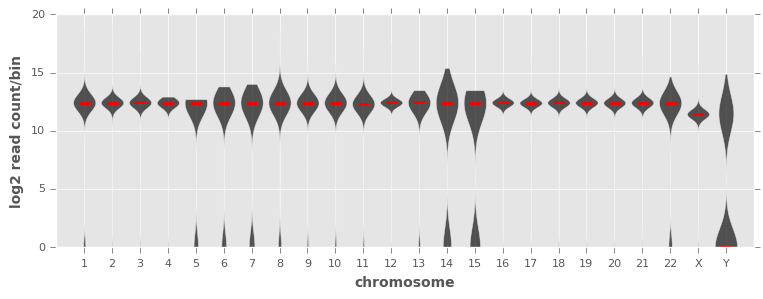

In [6]:
plt.figure(figsize=(9, 3))
vp = plt.violinplot([np.log2(bins['count']+1) for chrom, bins in covs.groupby('chrom')],
                    showextrema=False, showmedians=True, widths=0.8)
plt.setp(vp['bodies'], facecolor='k', alpha=.65)
plt.setp(vp['cmedians'], lw=2)

# chromosome 번호로 X 축 레이블을 단다.
chromosomes = covs['chrom'].unique()
plt.xticks(np.arange(1, len(chromosomes) + 1),
           [c[3:] for c in chromosomes])

plt.xlabel('chromosome')
plt.ylabel('log2 read count/bin')

In [7]:
import six

import numpy as np
import matplotlib.pyplot as plt
from matplotlib import colors

colors_ = list(six.iteritems(colors.cnames))

# Add the single letter colors.
for name, rgb in six.iteritems(colors.ColorConverter.colors):
    hex_ = colors.rgb2hex(rgb)
    colors_.append((name, hex_))

# Transform to hex color values.
hex_ = [color[1] for color in colors_]
# Get the rgb equivalent.
rgb = [colors.hex2color(color) for color in hex_]
# Get the hsv equivalent.
hsv = [colors.rgb_to_hsv(color) for color in rgb]

chroms = sorted(covs['chrom_sortkey'].unique())
chromcolors = {chrom: color for chrom, color
               in zip(chroms, hex_)}
chromcolors['chrY'] = '#3d3d3d'
print chromcolors

{'chrY': '#3d3d3d', 'chrX': u'#00FA9A', 'chr018': u'#98FB98', 'chr019': u'#2F4F4F', 'chr016': u'#FFDEAD', 'chr017': u'#00FF00', 'chr014': u'#F08080', 'chr015': u'#FF4500', 'chr012': u'#FFC0CB', 'chr013': u'#FF6347', 'chr010': u'#808000', 'chr011': u'#8FBC8F', 'chr022': u'#FFF5EE', 'chr021': u'#DEB887', 'chr020': u'#ADFF2F', 'chr009': u'#556B2F', 'chr008': u'#FFE4E1', 'chr005': u'#CD5C5C', 'chr004': u'#B22222', 'chr007': u'#FFFF00', 'chr006': u'#87AE73', 'chr001': u'#4B0082', 'chr003': u'#FF69B4', 'chr002': u'#FFD700'}


In [8]:
chroms = sorted(covs['chrom_sortkey'].unique())
chromcolors = {chrom: color for chrom, color
               in zip(chroms, colormap_lch(len(chroms), end=360))}
chromcolors['chrY'] = '#3d3d3d'

(4, 16)

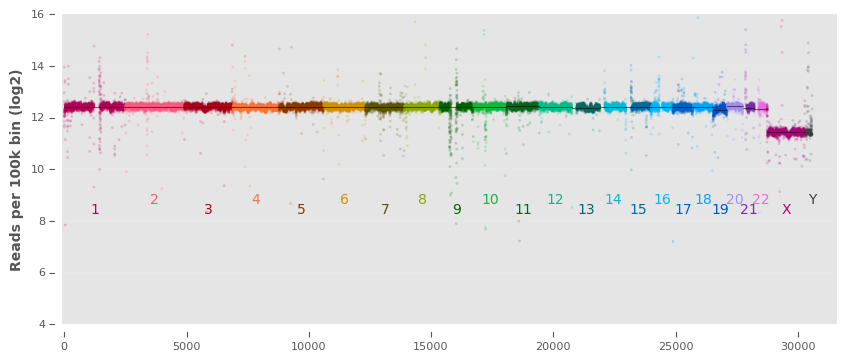

In [9]:
fig, ax = plt.subplots(1, 1, figsize=(10, 4))

chromnameY = 8.5
wiggle_y = .2

for i, (chrom, rows) in enumerate(covs.groupby('chrom_sortkey')):
    ax.scatter(rows.index, np.log2(rows['count']),
               edgecolor='none', s=4, alpha=0.2,
               c=chromcolors[chrom])

    center_y = np.median(np.log2(rows['count']).dropna())
    ax.plot([rows.index[0], rows.index[-1]],
            [center_y, center_y],
            c='black',linewidth=0.4)
    
    center_x = np.mean(rows.index)
    ax.annotate(chrom[3:].lstrip('0'),
                (center_x, chromnameY + (wiggle_y * (i % 2) * 2 - wiggle_y)),
                color=chromcolors[chrom], ha='center')

apply_dropped_spine(ax)

ax.set_ylabel('Reads per 100k bin (log2)')
ax.set_xlim(-100, 15800*2)
ax.set_ylim(4, 16)

이수성(aneuploidy)이 있으면 log2 스케일로 0.15 정도 위아래로 왔다갔다 할 것이다. trisomy가 있다면 22번이 아래로 내려온 정도로 위로 튀면 된다. trisomy가 가장 잘 발생하는 21번 (다운 증후군), 18번 (에드워즈 증후군), 13번 (파타우 증후군) 염색체들은 다행히도 대충 대세를 따른다. 사실 이렇게 한 데이터만 놓고서 분석해서는 정확히 알기는 힘들고, 같은 플랫폼에서 검사한 다른 사람들의 데이터가 많이 모여야 정상치의 범위를 알 수 있는데.. 일단은 데이터가 1개 밖에 없으니 이걸로 대충 보고 만족한다

In [10]:
#/NGENEBIO/workflow-app/bedtools2-2.19.0/bin/bedtools makewindows -g hg19.chrom.sizes -w 100000 > bins
#/NGENEBIO/workflow-app/bedtools2-2.19.0/bin/bedtools nuc -fi /NGENEBIO/workflow-dependencies/hg19.fa -bed bins > a

In [11]:
nuccomp = pd.read_table("gc.txt",usecols=range(5))
nuccomp.columns = ['chrom', 'start', 'end', 'pct_at', 'pct_gc']
nuccomp.head()

,chrom,start,end,pct_at,pct_gc
0,chr1,0,100000,0.51793,0.38207
1,chr1,100000,200000,0.43655,0.33762
2,chr1,200000,300000,0.24526,0.15776
3,chr1,300000,400000,0.49200,0.33081
4,chr1,400000,500000,0.38987,0.32381


In [12]:
nuccomp['pct_gc'] = nuccomp['pct_gc'] / (nuccomp['pct_gc'] + nuccomp['pct_at'])
del nuccomp['pct_at']

In [13]:
nuccomp.head()

,chrom,start,end,pct_gc
0,chr1,0,100000,0.424522
1,chr1,100000,200000,0.436106
2,chr1,200000,300000,0.391445
3,chr1,300000,400000,0.402049
4,chr1,400000,500000,0.453719


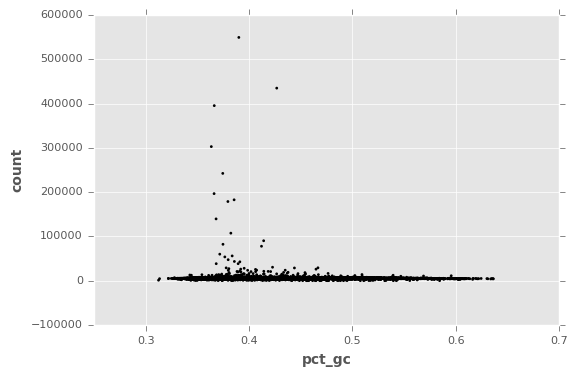

In [14]:
covs_with_gc = pd.merge(covs, nuccomp, left_on=['chrom', 'start', 'end'],
                        right_on=['chrom', 'start', 'end']).dropna()
covs_with_gc.plot(kind='scatter', x='pct_gc', y='count',
                  edgecolor='none', s=4, c='black')

GC 비율과 카운트가 관계가 있는지 살펴본다.

In [15]:
covs_with_gc.head()

,chrom,start,end,count,nzpos,length,nzratio,chrom_sortkey,pct_gc
0,chr1,0,100000,8009,87277,100000,0.87277,chr001,0.424522
1,chr1,100000,200000,4957,74409,100000,0.74409,chr001,0.436106
2,chr1,200000,300000,3182,38946,100000,0.38946,chr001,0.391445
3,chr1,300000,400000,3356,74267,100000,0.74267,chr001,0.402049
4,chr1,400000,500000,3697,68252,100000,0.68252,chr001,0.453719


In [16]:
from scipy.stats import gaussian_kde
gc_count_mtx = covs_with_gc[['pct_gc', 'count']].as_matrix().T
density = gaussian_kde(gc_count_mtx, bw_method=0.1)(gc_count_mtx)

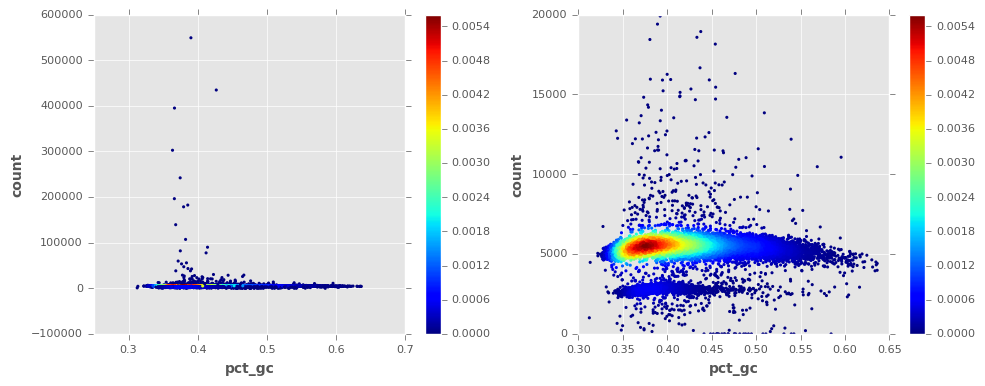

In [17]:
fig, axes = plt.subplots(1, 2, figsize=(10, 4))

covs_with_gc.plot(kind='scatter', x='pct_gc', y='count', edgecolor='none', s=5,
                  c=density, vmin=0, cmap='jet', ax=axes[0])
covs_with_gc.plot(kind='scatter', x='pct_gc', y='count', edgecolor='none', s=5,
                  c=density, vmin=0, cmap='jet', ax=axes[1])
axes[1].set_ylim(-1, 20000)
axes[1].set_xlim(0.3, 0.65)

plt.tight_layout()

In [18]:
def loess_fit(x, y, px=None, model=None, alpha=0.5):
    from rpy2 import robjects as ro

    if model is None:
        model = ro.r('y ~ x')

    if px is None:
        px = np.linspace(min(x), max(y), 22)[1:-1]

    fitframe = ro.DataFrame({'x': ro.FloatVector(x), 'y': ro.FloatVector(y)})
    loessmodel = ro.r.loess(model, fitframe, span=alpha)

    predframe = ro.DataFrame({'x': ro.FloatVector(px)})
    predy = ro.r.predict(loessmodel, predframe)
    preddata = [(x, predy[i]) for i, x in enumerate(px)]

    return np.array(preddata).transpose()

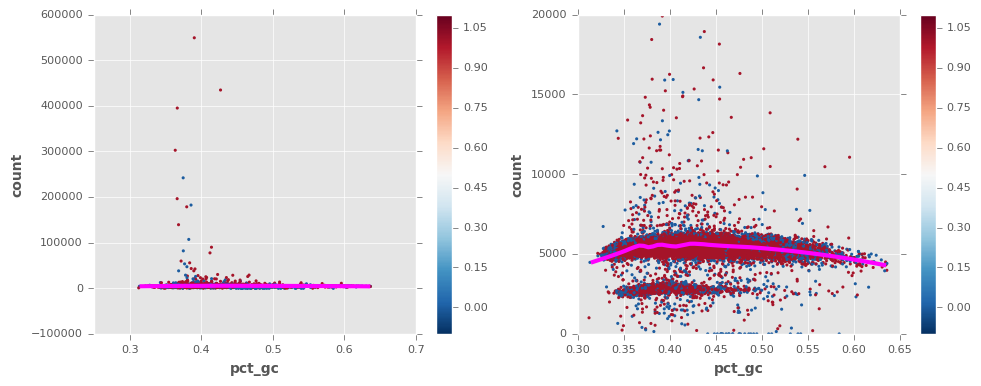

In [19]:
from sklearn import svm

gc_count_mtx_training = gc_count_mtx[:, gc_count_mtx[1] > 90]
model = svm.OneClassSVM(nu=0.06, kernel="rbf", gamma=0.5).fit(gc_count_mtx_training.T)
isinlier = model.predict(gc_count_mtx.T) == 1

gc_count_inliers = gc_count_mtx[:, isinlier]
fit_x, fit_y = loess_fit(gc_count_inliers[0], gc_count_inliers[1],
                               np.linspace(0, 1, 200), alpha=.4)

fig, axes = plt.subplots(1, 2, figsize=(10, 4))

covs_with_gc.plot(kind='scatter', x='pct_gc', y='count', edgecolor='none', s=5,
                  c=isinlier, vmin=-.1, vmax=1.1, cmap='RdBu_r', ax=axes[0])
covs_with_gc.plot(kind='scatter', x='pct_gc', y='count', edgecolor='none', s=5,
                  c=isinlier, vmin=-.1, vmax=1.1, cmap='RdBu_r', ax=axes[1])
axes[1].set_ylim(-1, 20000)
axes[1].set_xlim(0.3, 0.65)

axes[1].plot(fit_x, fit_y, c='magenta', lw=3)
axes[0].plot(fit_x, fit_y, c='magenta', lw=3)

plt.tight_layout()

In [20]:
gc_inliers_center = np.vstack(loess_fit(gc_count_inliers[0], gc_count_inliers[1],
                                              gc_count_inliers[0], alpha=.4))

gc_logenr = gc_count_inliers.copy()
gc_logenr[1] = np.log2(gc_count_inliers[1] / gc_inliers_center[1])

orig_density = gaussian_kde(gc_count_inliers, bw_method=0.1)(gc_count_inliers)
adj_density = gaussian_kde(gc_logenr, bw_method=0.1)(gc_logenr)

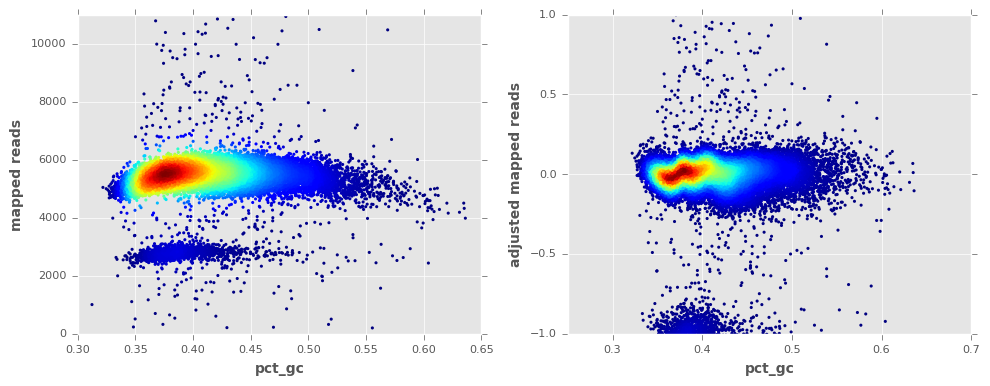

In [21]:
fig, axes = plt.subplots(1, 2, figsize=(10, 4))

axes[0].scatter(gc_count_inliers[0], gc_count_inliers[1], c=orig_density, edgecolor='none', s=5)
axes[0].set_xlabel('pct_gc')
axes[0].set_ylabel('mapped reads')
axes[0].set_ylim(-1, 11000)
axes[0].set_xlim(0.3, 0.65)

axes[1].scatter(gc_logenr[0], gc_logenr[1], c=adj_density, edgecolor='none', s=5)
axes[1].set_xlabel('pct_gc')
axes[1].set_ylabel('adjusted mapped reads')
axes[1].set_ylim(-1, 1)

plt.tight_layout()

In [22]:
_, expected = loess_fit(gc_count_inliers[0], gc_count_inliers[1],
                              covs_with_gc['pct_gc'], alpha=.4)
covs_w_logenr = covs_with_gc.copy()
covs_w_logenr['log2enrichment'] = np.log2(covs_w_logenr['count'] / expected)
covs_w_logenr = covs_w_logenr[covs_w_logenr['count'] > 0].dropna()

-0.96969696969696972

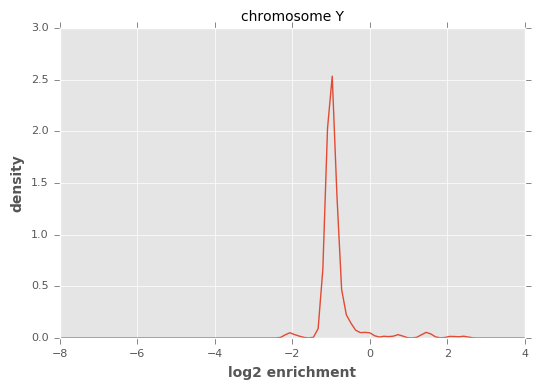

In [23]:
chrY_enrichment = covs_w_logenr[covs_w_logenr['chrom'] == 'chrY']['log2enrichment']
xv = np.linspace(-8, 4, 100)
yv = gaussian_kde(chrY_enrichment, bw_method=0.2)(xv)
plt.plot(xv, yv)
plt.xlabel('log2 enrichment')
plt.ylabel('density')
plt.title('chromosome Y')
xv[np.argmax(yv)]

(-4, 1)

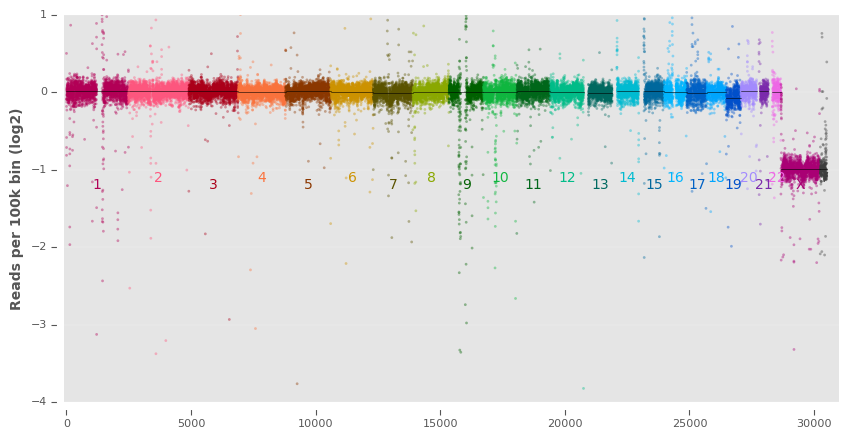

In [24]:
fig, ax = plt.subplots(1, 1, figsize=(10, 5))

chromnameY = -1.2
wiggle_y = .05

for i, (chrom, rows) in enumerate(covs_w_logenr.groupby('chrom_sortkey')):
    ax.scatter(rows.index, rows['log2enrichment'],
               edgecolor='none', s=4, alpha=0.4,
               c=chromcolors[chrom])

    center_y = np.median(rows['log2enrichment'].dropna())
    ax.plot([rows.index[0], rows.index[-1]],
            [center_y, center_y],
            c='black',linewidth=0.4)
    
    center_x = np.mean(rows.index)
    ax.annotate(chrom[3:].lstrip('0'),
                (center_x, chromnameY + (wiggle_y * (i % 2) * 2 - wiggle_y)),
                color=chromcolors[chrom], ha='center')

apply_dropped_spine(ax)

ax.set_ylabel('Reads per 100k bin (log2)')
ax.set_xlim(-100, 31000)
ax.set_ylim(-4, 1)

In [25]:
# wget http://hgdownload.soe.ucsc.edu/goldenPath/hg38/database/snp146.txt.gz
# wget http://hgdownload.soe.ucsc.edu/goldenPath/hg19/database/snp146.txt.gz
# convert snp to bed
# zcat snp146.txt.gz | cut -f2-7 |gzip -c -> snp146.bed.gz
# zcat snp146.bed.gz |grep chr1 |gzip -c -> snp146_chr1.bed.gz

In [26]:
snptbl = pd.read_table('snp146_chr20.bed.gz', compression='gzip',
                       names=['chrom', 'start', 'end', 'name', 'score', 'strand'])
snptbl.head()

,chrom,start,end,name,score,strand
0,chr20,60038,60039,rs772768480,0,+
1,chr20,60308,60309,rs574852966,0,+
2,chr20,60342,60343,rs527639301,0,+
3,chr20,60365,60366,rs762720439,0,+
4,chr20,60418,60419,rs538242240,0,+


In [27]:
#snpcalls_m = pd.read_table('genome_Hong_ChangBum_Full_20100816082459.txt',
snpcalls_m = pd.read_table('genome_Hyungyong_Kim_Full_20110427172039.txt',
                       comment='#', names=['name', 'chrom', 'position', 'genotype'],
                       low_memory=False)
snpcalls_f = pd.read_table('genome_Tim_Boyle_v4_Full_20160916220037.txt',
                       comment='#', names=['name', 'chrom', 'position', 'genotype'],
                       low_memory=False)
snpcalls_f.head()

,name,chrom,position,genotype
0,rs12564807,1,734462,AA
1,rs3131972,1,752721,AG
2,rs148828841,1,760998,CC
3,rs12124819,1,776546,AA
4,rs115093905,1,787173,--


In [28]:
snpcalls = pd.merge(
    snpcalls_m[['name', 'genotype']], snpcalls_f[['name', 'genotype']],
    how='inner', left_on='name', right_on='name', suffixes=['_mo', '_fa'])

In [29]:
snpcalls.head()

,name,genotype_mo,genotype_fa
0,rs3934834,CC,CC
1,rs11260588,GG,GG
2,rs6687776,CC,CC
3,rs9651273,GG,GG
4,rs4970405,AA,AA


In [30]:
snpmerged = pd.merge(snptbl, snpcalls, how='inner', left_on='name', right_on='name')
snpmerged.to_csv('snpcalls.bed.gz', compression='gzip', header=False, index=False, sep='\t')

In [31]:
snpmerged.head()

,chrom,start,end,name,score,strand,genotype_mo,genotype_fa
0,chr20,63243,63244,rs6139074,0,+,AC,AC
1,chr20,63798,63799,rs1418258,0,+,CT,CT
2,chr20,68748,68749,rs6086616,0,+,CT,CC
3,chr20,69093,69094,rs6039403,0,+,GG,AG
4,chr20,74346,74347,rs6135141,0,+,AG,GG


In [32]:
# del snptbl, snpcalls_m, snpcalls_f, snpcalls
# samtools mpileup -l snpcalls.bed.gz HG00650.mapped.ILLUMINA.bwa.CHS.low_coverage.20101123.bam | cut -f1,2,4,5,6 | gzip -c - > snpmatched.txt.gz

In [33]:
serum_snps = pd.read_table('snpmatched.txt.gz', compression='gzip',
                          names=['chrom', 'position', 'reads', 'basecalls', 'basequalities'])
serum_snps['position'] -= 1

In [34]:
serum_snps.head()

,chrom,position,reads,basecalls,basequalities
0,chr20,63243,4,CACc,ACAB
1,chr20,63798,4,cCcc,B?>D
2,chr20,68748,6,CCTCtc,BACAA4
3,chr20,69093,4,Gaga,BCBC
4,chr20,74346,1,g$,A


In [35]:
parental_snps =  pd.read_table('snpcalls.bed.gz', compression='gzip',
                          names=['chrom', 'start', 'end', 'name', 'score', 'strand',
                                 'mother', 'father'])

In [36]:
parental_snps.head()

,chrom,start,end,name,score,strand,mother,father
0,chr20,63243,63244,rs6139074,0,+,AC,AC
1,chr20,63798,63799,rs1418258,0,+,CT,CT
2,chr20,68748,68749,rs6086616,0,+,CT,CC
3,chr20,69093,69094,rs6039403,0,+,GG,AG
4,chr20,74346,74347,rs6135141,0,+,AG,GG


In [37]:
snps = pd.merge(parental_snps, serum_snps,
                how='inner', right_on=['chrom', 'position'],
                left_on=['chrom', 'start']).dropna()

In [38]:
snps.head()

,chrom,start,end,name,score,strand,mother,father,position,reads,basecalls,basequalities
0,chr20,63243,63244,rs6139074,0,+,AC,AC,63243,4,CACc,ACAB
1,chr20,63798,63799,rs1418258,0,+,CT,CT,63798,4,cCcc,B?>D
2,chr20,68748,68749,rs6086616,0,+,CT,CC,68748,6,CCTCtc,BACAA4
3,chr20,69093,69094,rs6039403,0,+,GG,AG,69093,4,Gaga,BCBC
4,chr20,74346,74347,rs6135141,0,+,AG,GG,74346,1,g$,A


In [39]:
import re

called_homozygote = lambda gt: gt[0] == gt[1] if len(gt) == 2 and gt[0] != '-' else False
def classify_homozygotic_parental_snps(basereads, maternal, paternal,
                                       pat=re.compile('([+-][0-9]+)?([ACGTNacgtn])')):
    r = [0, 0, 0] # maternal matched, paternal matched, matched to neither of them
    for indelmark, base in pat.findall(basereads):
        if indelmark or base in 'nN':
            pass # skip it to simplify the analysis.

        ubase = base.upper()
        if ubase == maternal:
            r[0] += 1
        elif ubase == paternal:
            r[1] += 1
        else:
            r[2] += 1
    return r

In [40]:
snps_mofa_diffs = snps[snps['mother'] != snps['father']].copy()
snps_mofa_diffs.head()

,chrom,start,end,name,score,strand,mother,father,position,reads,basecalls,basequalities
2,chr20,68748,68749,rs6086616,0,+,CT,CC,68748,6,CCTCtc,BACAA4
3,chr20,69093,69094,rs6039403,0,+,GG,AG,69093,4,Gaga,BCBC
4,chr20,74346,74347,rs6135141,0,+,AG,GG,74346,1,g$,A
6,chr20,87415,87416,rs1935386,0,+,AA,CC,87415,9,aAaaAaaAa,CBCBBCCB9
8,chr20,91706,91707,rs8122066,0,+,CT,CC,91706,1,c,A


In [41]:
snps_homo_homo = snps_mofa_diffs[
    snps_mofa_diffs['mother'].apply(called_homozygote) &
    snps_mofa_diffs['father'].apply(called_homozygote)]

In [42]:
snps_homo_homo.head()

,chrom,start,end,name,score,strand,mother,father,position,reads,basecalls,basequalities
6,chr20,87415,87416,rs1935386,0,+,AA,CC,87415,9,aAaaAaaAa,CBCBBCCB9
71,chr20,360788,360789,rs6139007,0,+,CC,TT,360788,3,tTT,@A@
91,chr20,443797,443798,rs205898,0,+,GG,AA,443797,4,agAg,B=B>
93,chr20,462007,462008,rs459012,0,+,TT,CC,462007,4,TTtT,BBC@
106,chr20,543743,543744,rs204694,0,+,TT,CC,543743,3,ccC,AAB


In [43]:
snpcounts_homo_homo = pd.DataFrame(
    snps_homo_homo.apply(lambda row:
                         classify_homozygotic_parental_snps(row['basecalls'], row['mother'][0],
                                                            row['father'][0]), axis=1).tolist(),
    index=snps_homo_homo.index,
    columns='mother father mismatched'.split())

In [44]:
snpcounts_homo_homo.head()

,mother,father,mismatched
6,9,0,0
71,0,3,0
91,2,2,0
93,4,0,0
106,0,3,0


In [45]:
snpcounts_homo_homo.sum(axis=0)

mother        2958
father        1807
mismatched       2
dtype: int64

In [46]:
float(1808)/(float(1807)+float(2958))*100*2

75.88667366211962

In [47]:
float(2958)/(float(1807)+float(2958))*100*2

124.15529905561384

In [48]:
def iter_snpcall_reads(tbl):
    parse_basecalls = re.compile('([+-][0-9]+)?([ACGTNacgtn])')
    for _, row in tbl.iterrows():
        maternaltype = row['mother'][0]
        paternaltype = row['father'][0]
        basecalls = parse_basecalls.findall(row['basecalls'])
        for (indel, baseread), phredqual in zip(basecalls, row['basequalities']):
            if not indel and baseread not in 'nN':
                yield row['chrom'], row['position'], baseread.upper(), ord(phredqual) - 33, maternaltype, paternaltype

In [49]:
homosnpreads = pd.DataFrame.from_records(iter_snpcall_reads(snps_homo_homo),
                                         columns=['chrom', 'position', 'baseread', 'quality', 'maternal', 'paternal'])

In [50]:
homosnpreads.head()

,chrom,position,baseread,quality,maternal,paternal
0,chr20,87415,A,34,A,C
1,chr20,87415,A,33,A,C
2,chr20,87415,A,34,A,C
3,chr20,87415,A,33,A,C
4,chr20,87415,A,33,A,C


In [51]:
assert (homosnpreads['baseread'] == homosnpreads['maternal']).sum()

In [52]:
maternal_reads = \
    homosnpreads[(homosnpreads['baseread'] == homosnpreads['maternal'])]
paternal_reads = \
    homosnpreads[(homosnpreads['baseread'] == homosnpreads['paternal'])]
mismatched_reads = \
    homosnpreads[(homosnpreads['baseread'] != homosnpreads['maternal']) &
                 (homosnpreads['baseread'] != homosnpreads['paternal'])]

In [53]:
def prepare_cumulative(grp, width=100, reverse=False):
    grp = sorted(grp)
    xvalues = [grp[int(i / width * (len(grp)-1))] for i in range(width+1)]
    yvalues = np.arange(width+1) / width
    if reverse:
        yvalues = yvalues[::-1]
    return xvalues, yvalues

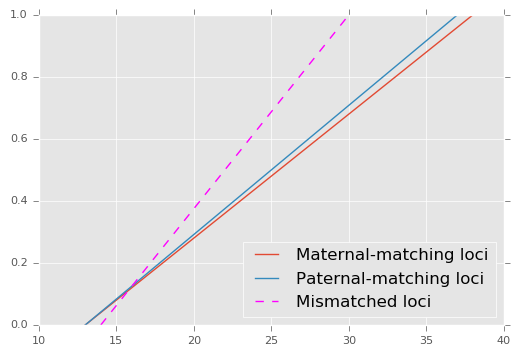

In [61]:
mat_x, mat_y = prepare_cumulative(maternal_reads['quality'])
pat_x, pat_y = prepare_cumulative(paternal_reads['quality'])
mismatched_x, mismatched_y = prepare_cumulative(mismatched_reads['quality'])

plt.plot(mat_x, mat_y, label='Maternal-matching loci')
plt.plot(pat_x, pat_y, label='Paternal-matching loci')
plt.plot(mismatched_x, mismatched_y, label='Mismatched loci', ls='--', c='magenta')
plt.legend(loc='best', fontsize=12)

In [55]:
r = []
for chrom, grp in homosnpreads.groupby('chrom'):
    if len(chrom) > 5:
        continue
    maternal_reads =  grp[(grp['baseread'] == grp['maternal'])]
    paternal_reads = grp[(grp['baseread'] == grp['paternal'])]
    mismatched_reads = grp[(grp['baseread'] != grp['maternal']) &
                           (grp['baseread'] != grp['paternal'])]
    r.append((chrom, len(maternal_reads), len(paternal_reads), len(mismatched_reads)))
    
homosnpmatches = pd.DataFrame(r, columns=['chrom', 'maternal', 'paternal', 'mismatched'])
homosnpmatches['p2m_ratio'] = homosnpmatches['paternal'] / (homosnpmatches['maternal'] + homosnpmatches['paternal'])
homosnpmatches.sort_values(by='p2m_ratio')

,chrom,maternal,paternal,mismatched,p2m_ratio
0,chr20,2958,1807,2,0.379224


In [56]:
%load_ext rpy2.ipython
%R pbinom(20, 157+20, 0.065, lower.tail=FALSE)

array([ 0.00574275])

In [57]:
snps_homo_hetero = snps_mofa_diffs[
    snps_mofa_diffs['mother'].apply(called_homozygote) &
    ~snps_mofa_diffs['father'].apply(called_homozygote)]

def iter_snpcall_reads_father_hetero(tbl):
    parse_basecalls = re.compile('([+-][0-9]+)?([ACGTNacgtn])')
    for _, row in tbl.iterrows():
        maternaltype = row['mother'][0]
        paternaltype = ''.join(set(row['father']) - set(maternaltype))
        if maternaltype == '-' or paternaltype == '-':
            continue
        basecalls = parse_basecalls.findall(row['basecalls'])
        for (indel, baseread), phredqual in zip(basecalls, row['basequalities']):
            if not indel and baseread not in 'nN':
                yield row['chrom'], row['position'], baseread.upper(), ord(phredqual) - 33, maternaltype, paternaltype

snpreads_fhetero = pd.DataFrame.from_records(iter_snpcall_reads_father_hetero(snps_homo_hetero),
                                         columns=['chrom', 'position', 'baseread', 'quality', 'maternal', 'paternal'])

In [58]:

r = []
for chrom, grp in snpreads_fhetero.groupby('chrom'):
    if len(chrom) > 5:
        continue
    maternal_reads =  grp[(grp['baseread'] == grp['maternal'])]
    paternal_reads = grp[(grp['baseread'] == grp['paternal'])]
    mismatched_reads = grp[(grp['baseread'] != grp['maternal']) &
                           (grp['baseread'] != grp['paternal'])]
    r.append((chrom, len(maternal_reads), len(paternal_reads), len(mismatched_reads)))
    
snpmatches_fhetero = pd.DataFrame(r, columns=['chrom', 'maternal', 'paternal', 'mismatched'])
snpmatches_fhetero['p2m_ratio'] = snpmatches_fhetero['paternal'] / (snpmatches_fhetero['maternal'] + snpmatches_fhetero['paternal'])
snpmatches_fhetero.sort_values(by='p2m_ratio')

,chrom,maternal,paternal,mismatched,p2m_ratio
0,chr20,7689,2425,5,0.239767
